In [156]:
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt

In [157]:
data_path = "data/spotify.csv"
try:
    df = pd.read_csv(data_path)
except:
    # Achtung der Pfad "../../../_Daten" muss existieren.
    import kagglehub
    import shutil
    # Download latest version
    path = kagglehub.dataset_download("atharvasoundankar/spotify-global-streaming-data-2024")
    
    # Get the first file in path
    files = os.listdir(path)
    if len(files) == 0:
        raise ValueError("No files found in the downloaded dataset.")
    # Check if the data directory exists, if not create it
    if not os.path.exists("data"):
        os.makedirs("data")

    # Move the downloaded file to the desired directory
    shutil.move(os.path.join(path, files[0]), data_path)

    print("Spotifiy dataset downloaded successfully!")

In [158]:
df.head()

,Country,Artist,Album,Genre,Release Year,Monthly Listeners (Millions),Total Streams (Millions),Total Hours Streamed (Millions),Avg Stream Duration (Min),Platform Type,Streams Last 30 Days (Millions),Skip Rate (%)
0,Germany,Taylor Swift,1989 (Taylor's Version),K-pop,2020,23.10,3695.53,14240.35,4.28,Free,118.51,2.24
1,Brazil,The Weeknd,After Hours,R&B,2023,60.60,2828.16,11120.44,3.90,Premium,44.87,23.98
2,United States,Post Malone,Austin,Reggaeton,2019,42.84,1425.46,4177.49,4.03,Free,19.46,4.77
3,Italy,Ed Sheeran,Autumn Variations,K-pop,2019,73.24,2704.33,12024.08,3.26,Premium,166.05,25.12
4,Italy,Ed Sheeran,Autumn Variations,R&B,2019,7.89,3323.25,13446.32,4.47,Free,173.43,15.82


In [159]:
df.keys()

Index(['Country', 'Artist', 'Album', 'Genre', 'Release Year',
       'Monthly Listeners (Millions)', 'Total Streams (Millions)',
       'Total Hours Streamed (Millions)', 'Avg Stream Duration (Min)',
       'Platform Type', 'Streams Last 30 Days (Millions)', 'Skip Rate (%)'],
      dtype='object')

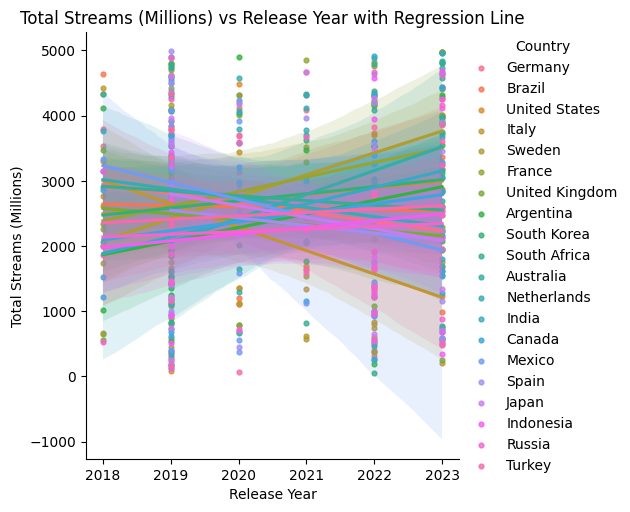

In [160]:
# Drawing a regression line between Release Year and total streams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

x_name = 'Release Year'
y_name = 'Total Streams (Millions)'
category_name = 'Country'

# Filter the DataFrame to include only the relevant columns
df_filtered = df[[x_name, y_name, category_name]].dropna()

# Convert the Release Year to numeric
df_filtered[x_name] = pd.to_numeric(df_filtered[x_name], errors='coerce')

# Drop rows with NaN values after conversion
df_filtered = df_filtered.dropna()

# Fitting regression model
X = df_filtered[[x_name]].values.reshape(-1, 1)
y = df_filtered[y_name].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
# Plotting the data and the regression line with confidence intervals

sns.lmplot(
    data=df_filtered, 
    x=x_name, 
    y=y_name,
    hue=category_name, 
    ci= 95,
    scatter_kws={'s':12},)
plt.title(f'{y_name} vs {x_name} with Regression Line')
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

# Entscheidungsbaum


In [161]:
# Regressionsentscheidungsbaum zur Vorhersage der Skip Rate (%) mit Kodierung kategorialer Variablen
# Kategoriale Variablen werden automatisch per One-Hot-Encoding kodiert.
# Feature- und Zielspalten
feature_cols = [
    'Country', 
    'Artist', 
    'Album', 
    'Genre', 
    'Release Year',
    'Monthly Listeners (Millions)', 
    'Total Streams (Millions)',
    'Total Hours Streamed (Millions)', 
    'Avg Stream Duration (Min)',
    'Streams Last 30 Days (Millions)'
]
target_col = 'Skip Rate (%)'

# Filtere und bereite die Daten vor
df_reg = df[feature_cols + [target_col]].dropna()
X = df_reg[feature_cols]
y = df_reg[target_col]

# Kategoriale Variablen kodieren mit One-Hot-Encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Splitte die Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [162]:
# Grid Search zur Optimierung der Entscheidungsbaum-Parameter
param_grid = {
    'max_depth': [4, 6, 8, 12, None],
    'min_impurity_decrease': [0.0, 0.01, 0.1, 0.5],
    'min_samples_split': [2, 5, 10, 20]
}

grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search.fit(X_encoded, y)

print("Beste Parameterkombination:")
print(grid_search.best_params_)
print(f"Bester mittlerer R²-Score: {grid_search.best_score_:.3f}")

# Optional: Ergebnisse als DataFrame anzeigen
# results_df = pd.DataFrame(grid_search.cv_results_)
# display(results_df[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False).head(10))

Beste Parameterkombination:
{'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_samples_split': 10}
Bester mittlerer R²-Score: -0.174


In [163]:

# Trainiere den Regressionsbaum
reg_tree = DecisionTreeRegressor(**grid_search.best_params_, random_state=42)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_split=10, random_state=42)

In [164]:
# Cross-Validierung für den Regressionsentscheidungsbaum
splits = 5
cv = KFold(n_splits=splits, shuffle=True, random_state=42)

# R²-Scores
r2_scores = cross_val_score(reg_tree, X_encoded, y, cv=cv, scoring='r2')
print(f"Mittlerer R²-Score ({splits}-fold CV): {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")

# MSE-Scores (negativ, daher Vorzeichen umdrehen)
mse_scores = cross_val_score(reg_tree, X_encoded, y, cv=cv, scoring=make_scorer(mean_squared_error, greater_is_better=False))
print(f"Mittlerer MSE ({splits}-fold CV): {(-np.mean(mse_scores)):.3f} ± {np.std(mse_scores):.3f}")

Mittlerer R²-Score (5-fold CV): -0.124 ± 0.098
Mittlerer MSE (5-fold CV): 124.495 ± 10.063


In [165]:
# Vorhersage und Bewertung
y_pred = reg_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}, R2: {r2:.2f}")


MSE: 116.17, R2: -0.01


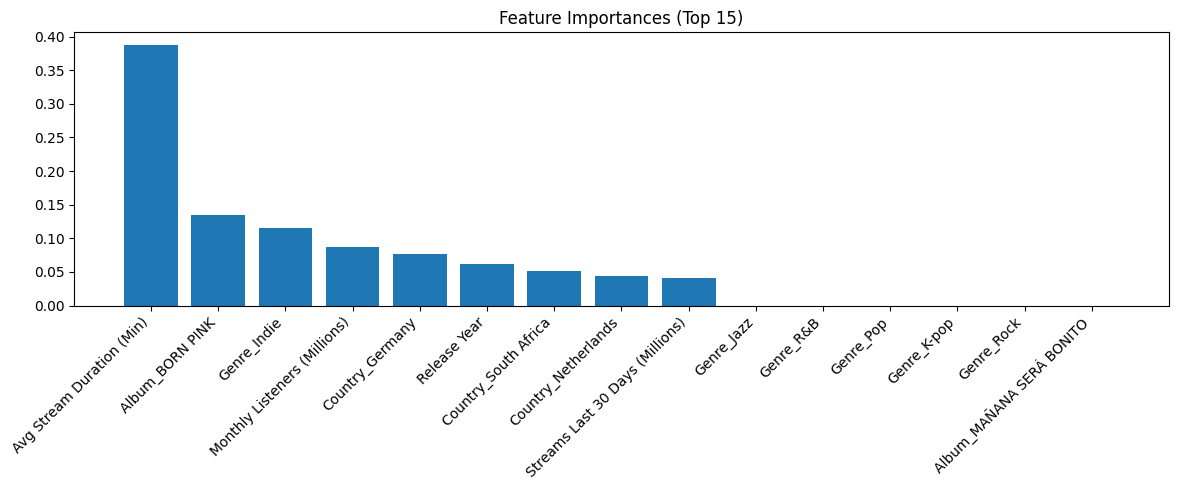

In [166]:
# Feature-Importances anzeigen
importances = reg_tree.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,5))
plt.title("Feature Importances (Top 15)")
# Zeige nur die wichtigsten 15 Features an
top_n = 15
plt.bar(range(top_n), importances[indices][:top_n], align="center")
plt.xticks(range(top_n), [X_encoded.columns[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

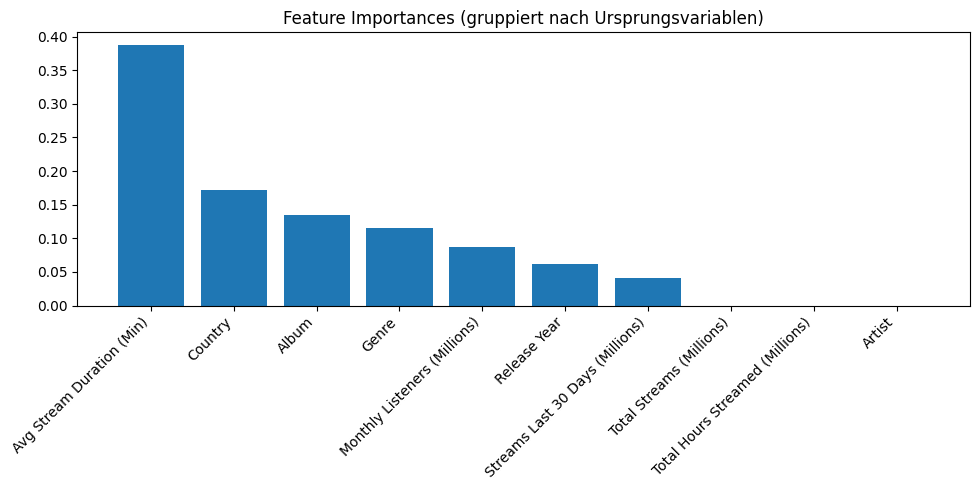

In [167]:
from collections import defaultdict

# Feature-Importances gruppiert nach Ursprungsvariablen anzeigen
importances = reg_tree.feature_importances_
feature_names = X_encoded.columns

# Ursprungsvariablen bestimmen
orig_vars = feature_cols

# Initialisiert ein Dictionary mit Listen für jede Ursprungsvariable
var_to_cols = defaultdict(list)
for col in feature_names:
    found = False
    for var in orig_vars:
        if col == var or col.startswith(var + '_'):
            var_to_cols[var].append(col)
            found = True
            break
    if not found:
        var_to_cols[col].append(col)  # falls neue Spalten auftauchen

# Importance pro Ursprungsvariable aufsummieren
summed_importances = {var: importances[[feature_names.get_loc(c) for c in cols]].sum() for var, cols in var_to_cols.items()}
# Sortieren
sorted_vars = sorted(summed_importances, key=summed_importances.get, reverse=True)

plt.figure(figsize=(10,5))
plt.title("Feature Importances (gruppiert nach Ursprungsvariablen)")
plt.bar(range(len(sorted_vars)), [summed_importances[v] for v in sorted_vars], align="center")
plt.xticks(range(len(sorted_vars)), sorted_vars, rotation=45, ha='right')
plt.tight_layout()
plt.show()